# Notebook 22: Outliers
***

In this notebook, we will take a closer look at the common Box-Cox transformation to transform non-normal data into something that is roughly normally distributed. There are many algorithms that rely on the assumption that the data being fed into the algorithm is normally distributed, so the Box-Cox transformation is frequently employed to satisfy these assumptions.

We'll need Numpy, Scipy-stats, Pandas and Pyplot for this notebook, so let's load them.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

<br>

### Exercise 1: Box-Cox Transformations

Read in the data set `boxcox.csv` and plot a histogram of the data. Describe the data set using words like "normal", "skewed" and "wacky".

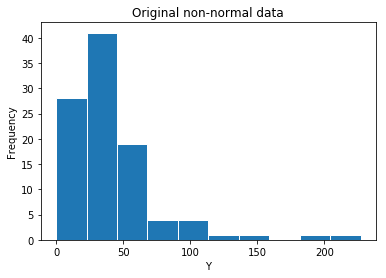

In [2]:
dfY = pd.read_csv("../data/boxcox.csv", header=None)
dfY.head()

plt.hist(dfY[0], edgecolor="white")
plt.xlabel("Y")
plt.ylabel("Frequency")
plt.title("Original non-normal data");

The data is decidedly non-normal, so before we try to weed out any outliers using Z-scores, we need to perform the Box-Cox transformation on this original data set $Y$. Recall, however, that the Box-Cox transformation depends on the parameter $\lambda$ to transform $Y$ into an approximately normally distributed set of data, $Y'$:
$$Y' = \begin{cases} \dfrac{Y^\lambda -1}{\lambda} & \lambda \neq 0 \\ \ln{Y} & \lambda = 0 \end{cases}$$

Try out a few values of $\lambda$. (Hint: it is not $\lambda = 0$.) Here's a try using $\lambda = 1$:

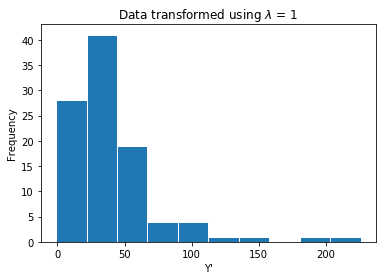

In [3]:
lam = 1
Yp = ((dfY[0]**lam)-1)/lam

plt.hist(Yp, edgecolor="white")
plt.xlabel("Y'")
plt.ylabel("Frequency")
plt.title("Data transformed using $\lambda$ = {}".format(lam));

Do you have a guess as to what $\lambda$ was used to create this data set? Come up with a guess, and argue loudly with your neighbors about whose guess is best.

<br>

Done arguing?  Great!

We can use the Scipy-stats function [stats.boxcox_llf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox_llf.html#scipy.stats.boxcox_llf) to compute the value of the log-likelihood function for the data set, given a particular estimate for the $\lambda$ parameter. Plug in the original data set, and your and your neighbors' guesses for $\lambda$ to see who was the closest to the value that maximizes the log-likelihood function!

In [4]:
lambda_guess = 1
llf = stats.boxcox_llf(data=dfY[0], lmb=lambda_guess)
print("Log-likelihood({}) = {:0.4f}".format(lambda_guess, llf))

Log-likelihood(1) = -354.0284


Now we can use the handy `stats.boxcox` function to actually perform maximum likelihood estimation for the $\lambda$ parameter:

In [5]:
Yp, lambda_hat = stats.boxcox(dfY[0])
print(lambda_hat)

0.331269937719789


How much better is this than other values of $\lambda$?  Use the `stats.boxcox_llf` function above but now evaluate it at a grid (or `linspace`) of lambda values spanning all the way from $[-4,4]$.  Is this a global maximum or a local one?

Now, make a histogram of the transformed data, using Yp from the `stats.boxcox` line above.


Horray! Looks pretty normal to me!

<br>

### Exercise 2: The Hunt for Outliers

Let's now analyze the transformed data set to find any potential outliers. We will use a threshold of 3 standard deviations away from the mean as our cutoff for labeling a data point as a potential outlier. Let's transform the data from our approximately normal transformed data set, $Y'$, into Z-scores:

In [6]:
Z = (Yp-Yp.mean())/Yp.std(ddof=1)

First, **a theoretical interlude**.

The Z-score represents how many standard deviations each data point is from their sample mean. Suppose we had an infinite supply of normal random samples. Just by random chance, what percentage of them do we expect to be more than 3 standard deviations away from their mean?

In [7]:
# SOLUTION:

**Solution:**

We expect to see about 0.27% of the samples outside of 3 standard deviations by random chance.

Find the indices of the data points where the transformed values are more than 3 standard deviations away from their mean. Which original data points are the potential outliers? How many of these potential outliers are there? Compare this proportion to the proportion you'd expect to see just be random chance.

In [8]:
# SOLUTION:

**Moral of the story:** We kept referring to the data points outside of 3 standard deviations as *potential* outliers because we are rarely 100% certain that they are outliers and not generated by the same process as the rest of the data. Outlier detection results must be treated with a grain of salt because just by random chance, we will see extreme measurements.

<br>

# -- code to generate the data set for the exercises --

<br>

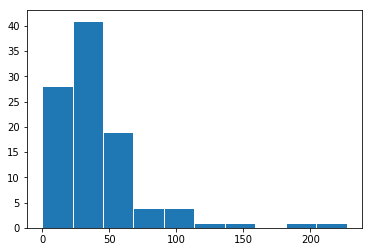

In [9]:
np.random.seed(4)
mu = 6.2
sig2 = 3.1
lam = 0.3
n = 100 # number of data points total
n_out = 4 # number of outliers artificially added
n_norm = n - n_out # number of data points from the normal distribution
x_norm = stats.norm.rvs(loc=mu, scale=np.sqrt(sig2), size=n_norm)
x_out_hi = stats.uniform.rvs(loc=mu+3*np.sqrt(sig2), scale=2*np.sqrt(sig2), size=n_out-1)
x_out_lo = stats.uniform.rvs(loc=mu-5*np.sqrt(sig2), scale=2*np.sqrt(sig2), size=1)
x = np.concatenate((x_norm, x_out_hi, x_out_lo))
idx_shuffle = np.random.choice(range(len(x)), size=len(x), replace=False)
x = x[idx_shuffle]
y = (lam*x + 1)**(1/lam)

plt.hist(y, edgecolor="white");

pd.DataFrame(y).to_csv("../data/boxcox.csv", index=False, header=False)

In [10]:
# Check it created the CSV nicely:
dfY = pd.read_csv("../data/boxcox.csv", header=None)
dfY.head()

,0
0,15.875682
1,52.625530
2,36.557848
3,34.197832
4,23.584636


Take a look at the above code.  Did you find all of the outliers?  Why or why not?  Plot the histogram of $Y$ again, but add markers for where the 4 true outliers were.  What does this say about finding outliers in general?

### Exercise 3: Using an iForest

Rather than implementing an iForest by hand, let's see if we can recover our outliers in the data set above using random forests.  Take a look at the documentation for sci-kit learn's iForest function.


In [11]:
from sklearn.ensemble import IsolationForest

In [31]:
y_forest=IsolationForest(contamination=.1).fit(dfY) #try also 'auto' for contamination
y_forest.predict(dfY)  #classifier; or we could extract anomoly scores directly.
#Usage NB: Can do training/holdout sets by using fit() on training set and predict() on holdout.
y_forest.decision_function()

array([-0.03062387])

Compare the indices flagged by the sk-learn iForest to those you found above.  What value(s) of "contamination" proportion give you the closest results to the actual generated data?